In [174]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from warnings import filterwarnings
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input

### 1. Импорт и предварительная обработка данных

In [2]:
#путь к датасету
train_dir = r'C:\GB\Diploms_exam\diplom\blood\dataset2-master\dataset2-master\images\TRAIN'
val_dir = r'C:\GB\Diploms_exam\diplom\blood\dataset2-master\dataset2-master\images\TEST_SIMPLE'
test_dir = r'C:\GB\Diploms_exam\diplom\blood\dataset2-master\dataset2-master\images\TEST'

In [3]:
#функцмя для сохранения данных о датасете в DataFrame 
def save_data_to_dataframe(dir, filename):
    filepaths = []
    labels = []
    folds = os.listdir(train_dir)
    for fold in folds:
        foldpath = os.path.join(train_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    df = pd.DataFrame({'filepaths':filepaths, 'labels' : labels })
    df.to_csv(filename)
    return df

In [4]:
#сохраним тренировочный, валидационный и тестовый датасеты
train_df = save_data_to_dataframe(train_dir, 'train_ds.csv')
val_df = save_data_to_dataframe(val_dir, 'val_ds.csv')
test_df = save_data_to_dataframe(test_dir, 'test_ds.csv')
train_df.head()

,filepaths,labels
0,C:\GB\Diploms_exam\diplom\blood\dataset2-maste...,EOSINOPHIL
1,C:\GB\Diploms_exam\diplom\blood\dataset2-maste...,EOSINOPHIL
2,C:\GB\Diploms_exam\diplom\blood\dataset2-maste...,EOSINOPHIL
3,C:\GB\Diploms_exam\diplom\blood\dataset2-maste...,EOSINOPHIL
4,C:\GB\Diploms_exam\diplom\blood\dataset2-maste...,EOSINOPHIL


In [5]:
#посмотрим на информацию
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9957 entries, 0 to 9956
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  9957 non-null   object
 1   labels     9957 non-null   object
dtypes: object(2)
memory usage: 155.7+ KB


In [6]:
train_df.iloc[0].filepaths
#путь сохраняется полностью

'C:\\GB\\Diploms_exam\\diplom\\blood\\dataset2-master\\dataset2-master\\images\\TRAIN\\EOSINOPHIL\\_0_1169.jpeg'

In [152]:
#Отметим классы изображений по колонке labels
class_names = train_df.labels.value_counts()
class_names

labels
NEUTROPHIL    2499
EOSINOPHIL    2497
LYMPHOCYTE    2483
MONOCYTE      2478
Name: count, dtype: int64

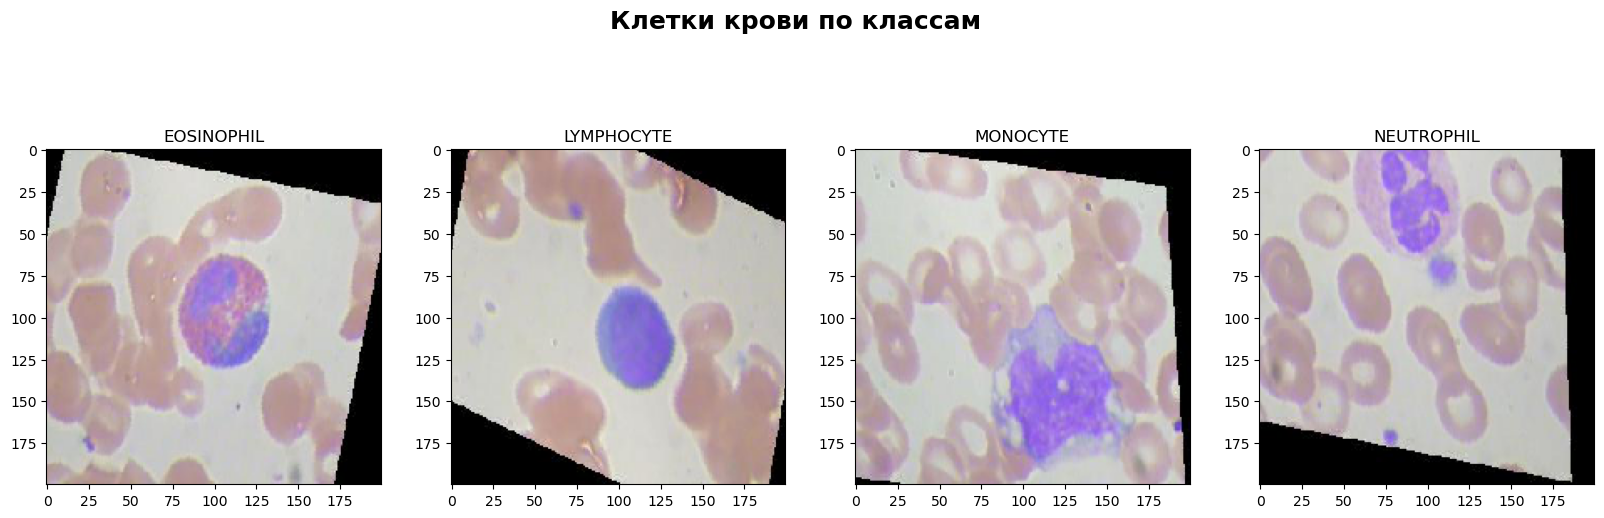

In [151]:
#посмотрим на изображения клеток
plt.figure(figsize=(20, 20))
plt.suptitle('Клетки крови по классам', color='black', fontsize=18, fontweight='bold', x=0.5, y=0.95, ha='center', va='top')
for i in range(len(class_names)):
    img = tf.keras.utils.load_img(train_df[train_df.labels == class_names[i]].iloc[0].filepaths, target_size=(200, 200))  
    plt.subplot(4, 4, i+1)
    plt.imshow(img)
    label = train_df[train_df.labels == class_names[i]].iloc[0].labels  #Берем первое изображение для каждого класса
    plt.title("{}".format(label), color='black', fontsize=12)  # Подписываем метку класса
    plt.axis('on')
plt.show()

In [156]:
#загрузим данные из тренировочной группы и сделаем их предварительный анализ
BATCH_SIZE = 32 # размер батча
IMG_HEIGHT = 224
IMG_WIDTH = 224
train_ds = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=(IMG_WIDTH, IMG_HEIGHT),
                                                                 batch_size=BATCH_SIZE,
                                                                 label_mode="int",
                                                                 shuffle=True,
                                                                 seed=42)

#Проверим полученные классы
class_names = train_ds.class_names
print(class_names)
len(train_ds)

Found 9957 files belonging to 4 classes.
['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


312

In [10]:
test_ds =  tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                                 image_size=(IMG_WIDTH, IMG_HEIGHT),
                                                                 batch_size=BATCH_SIZE,
                                                                 label_mode="int",
                                                                 shuffle=False,
                                                                 seed=42)
len(test_ds)

Found 2487 files belonging to 4 classes.


78

In [154]:
val_ds = tf.keras.utils.image_dataset_from_directory(directory=val_dir,
                                                                 image_size=(IMG_WIDTH, IMG_HEIGHT),
                                                                 batch_size=BATCH_SIZE,
                                                                 label_mode="int",
                                                                 shuffle=True,
                                                                 seed=42)
len(val_ds)

Found 71 files belonging to 4 classes.


3

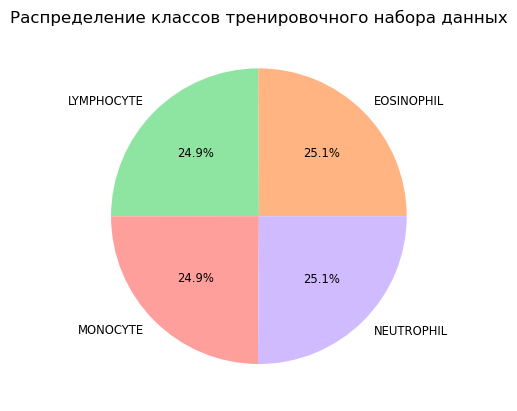

In [12]:
# Функция считает балланс классов 

def show_class_distribution(ds, name):
    labels = np.concatenate([label for image, label in ds], axis=0)
    unique, counts = np.unique(labels, return_counts=True)
    plt.pie(x=counts, labels=class_names, autopct='%.1f%%', textprops={'size': 'smaller'},
            colors=sns.color_palette('pastel')[1:9])
    plt.title(f'Распределение классов {name} набора данных')
    plt.show()
    
# Посмотрим балланс классов для тренировочного набора данных    
show_class_distribution(train_ds, 'тренировочного')

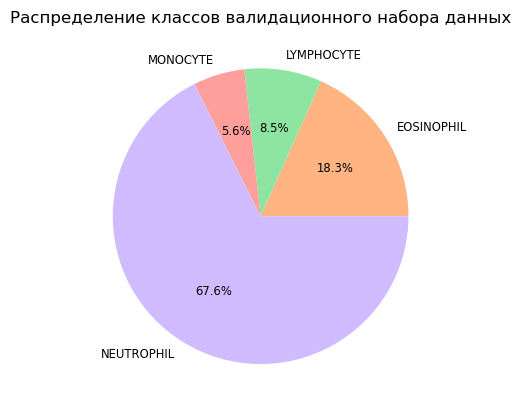

In [13]:
# Посмотрим балланс классов для валидационного набора данных  
show_class_distribution(val_ds, 'валидационного')

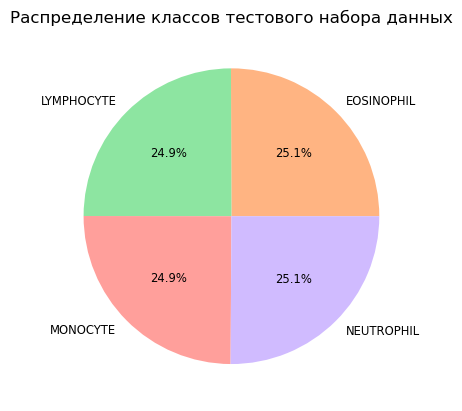

In [14]:
# Посмотрим балланс классов для тестового набора данных    
show_class_distribution(test_ds, 'тестового')

Из диаграмм видно, что тренировочный и тестовый наборы данных имеют сбалансированные классы, в валидационном наборе количество нейтрофилов значительно больше, чем других клеток, например в 11 раз больше чем моноцитов. Пока оставим валидационный набор таким, впоследствие заменим его на  сбалансированный набор, и посмотрим, как это отразится на результатах обучения моделей.

In [89]:
#Посмотрим метки классов тренировочного набора данных
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (32, 224, 224, 3)
Label:  [1 3 2 0 1 1 2 0 3 3 0 1 2 3 2 3 2 1 1 0 0 2 3 0 0 3 1 0 2 0 1 3]


In [15]:
# Наш набор данных дополненный (аугментированный), посмотрим как работает аугментация на примере слоя аугментации (в модели его использовать не будем)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.4)
    ])

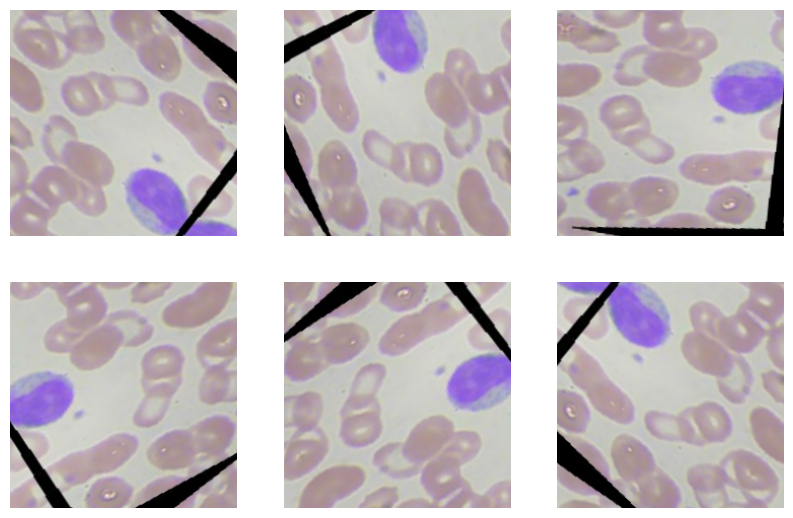

In [155]:
#Посмотрим, что он делает, для этого применим этот слои к одному и тому же изображению и посмотрим на результат.
filterwarnings('ignore')
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [177]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
# Функция подготовки данныхдля ввода в нейросеть
def ds_preprocessing(ds, name):
    ds = ds.map(lambda X, y: (preprocess_input(X), y)).prefetch(tf.data.AUTOTUNE)
    for image_batch, labels_batch in ds.take(1):
        print(f'{name} набор изображений: {image_batch.shape}')
        print(f'{name} набор меток: {labels_batch.shape}')

ds_preprocessing(train_ds, 'Тренировочный')
ds_preprocessing(test_ds, 'Тестовый')

Тренировочный набор изображений: (32, 224, 224, 3)
Тренировочный набор меток: (32,)
Тестовый набор изображений: (32, 224, 224, 3)
Тестовый набор меток: (32,)


In [178]:
ds_preprocessing(val_ds, 'Валидационный')

Валидационный набор изображений: (32, 224, 224, 3)
Валидационный набор меток: (32,)


In [184]:
for image, label in train_ds.take(1):
  print(tf.reduce_max(image))
  print(tf.reduce_min(image))

tf.Tensor(255.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


### 2.Дополнительные функции для работы с моделями

In [532]:
# Функция для отрисовки графиков
def show_history(history, name):
    filterwarnings('ignore')
    
    # Получаем данные из истории и определяем эпохи
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_acc) + 1)
    
    # Стороим графики
    fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    fig.text(s= f'{name} Accuracy и Loss  для train_ds и val_ds', size=18, fontweight='bold',
                 fontname='monospace', color='black', y=0.9, x=0.22, alpha=0.8)
    sns.despine()
    ax[0].plot(epochs, train_acc, marker='o', markerfacecolor='mediumpurple', color='mediumpurple',
               label='Training Accuracy')
    ax[0].plot(epochs, val_acc, marker='o', markerfacecolor='palegreen', color='palegreen',
               label='Validation Accuracy')
    ax[0].legend(frameon=False)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[1].plot(epochs, train_loss, marker='o', markerfacecolor='mediumpurple', color='mediumpurple',
               label='Training Loss')
    ax[1].plot(epochs, val_loss, marker='o', markerfacecolor='palegreen', color='palegreen',
               label='Validation Loss')
    ax[1].legend(frameon=False)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Training & Validation Loss')
    plt.show()

In [143]:
#Функция для построения матрицы ошибок ConfusionMatrix модели
def show_confusion_matrix(model, name):
    y_pred = []
    y_pred_proba = []
    y_true = []
    
    # Проходим по набору данных и сохраняем метки
    for image_batch, label_batch in test_ds:
       y_true.append(label_batch)
       preds = model.predict(image_batch, verbose=0)
       y_pred_proba.append(preds)
       y_pred.append(np.argmax(preds, axis=-1))
    
    # Объединим и преобразуем предсказанные и реальные метки 
    correct_labels = tf.concat([item for item in y_true], axis = 0)
    correct_labels = tf.cast(correct_labels, "int64")
    predicted_labels = tf.concat([item for item in y_pred], axis = 0)
    fig, axes = plt.subplots(figsize=(10,6))
    ConfusionMatrixDisplay.from_predictions(y_true=correct_labels,
                                        y_pred=predicted_labels,
                                        display_labels=class_names,
                                        normalize="true",
                                        cmap="Purples",
                                        values_format=".1%",
                                        colorbar=False,
                                        ax=axes)
    axes.set_xticklabels(labels=class_names, rotation=45,
                         ha='right',
                         rotation_mode='anchor')
    fig.text(s= f'{name} ConfusionMatrix', size=18, fontweight='bold',
                 fontname='monospace', color='black', y=1, x=0.28, alpha=0.8)
    plt.show()
    # Напечатаем отчет о проведенной кл
    print(
        "Classification report rebuilt from confusion matrix:\n"
        f"{classification_report(y_true=correct_labels, y_pred=predicted_labels, target_names=class_names)}\n"
    )

In [93]:
# Записи по результат тестирования моделей будем записывать в словарь
model_book = {}

#Функция записи данных модели в model_book
def write_model_book(model):
    train_accuracy = model.evaluate(train_ds)[1]
    val_accuracy = model.evaluate(val_ds)[1]
    test_accuracy = model.evaluate(test_ds)[1]
    model_book[name] = {"train_accuracy": train_accuracy, "val_accuracy": val_accuracy, "test_accuracy": test_accuracy}

### 3. Модель VGG19 feature extraction

Построим классификатор клеток крови и осуществим процесс Transfer learning с помощью модели VGG19. Все слои сети заморозим.

In [136]:
#имя сети
name = "VGG19"

In [173]:
#Будем сохранять контрольные точки модели во время обучения используя метод обратного вызова контрольной точки

# Путь к файлу
checkpoint_path = r'C:\GB\Diploms_exam\diplom\blood\dataset2-master\dataset2-master\model_best.keras'

# Определим аргументы для сохранения весов и контроля обучения модели
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    verbose=2,
    save_best_only=True,
    mode='max',
    save_weights_only=False
)

#Опредлим условия остановки обучения, если отслеживаемая метрика (val_loss) перестала улучшаться.
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=10,           
    restore_best_weights=True  
)

#Определим уменьшение скорости обучения, когда метрика (val_accuracy) перестала улучшаться.
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
# Загрузим предварительно обученную модель VGG19, отрежем ее верхний слой классификатор и заморозим оставшиеся слои
feature_extraction_layer = VGG19(include_top=False,
                                    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
feature_extraction_layer.trainable = False

In [222]:
feature_extraction_layer.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [139]:
# Построим модель с помощью функционала Keras.layers, добавим к замороженным слоям слой GlobalAvgPool2D и Dense слой с 4 выходами
tf.random.set_seed(42)
VGG19 = tf.keras.Sequential([feature_extraction_layer,
                            layers.GlobalAvgPool2D(),
                            layers.Dense(4, activation="softmax")
                            ], name=name)
# Скомпилируем модель
VGG19.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Обучаем полученную модель на обновленных набоах данных
history_VGG19 = VGG19.fit(train_ds,
                        validation_data=val_ds,
                        epochs=30,
                        callbacks=[checkpoint_callback, reduce_lr, early_stopping_callback])

Epoch 1/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3326 - loss: 2.2706
Epoch 1: val_accuracy improved from -inf to 0.56338, saving model to C:\GB\Diploms_exam\diplom\blood\dataset2-master\dataset2-master\model_best.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 1561s 6s/step - accuracy: 0.3329 - loss: 2.2682 - val_accuracy: 0.5634 - val_loss: 1.2850 - learning_rate: 0.0010
Epoch 2/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5638 - loss: 1.0579
Epoch 2: val_accuracy improved from 0.56338 to 0.61972, saving model to C:\GB\Diploms_exam\diplom\blood\dataset2-master\dataset2-master\model_best.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 1950s 8s/step - accuracy: 0.5639 - loss: 1.0576 - val_accuracy: 0.6197 - val_loss: 1.1089 - learning_rate: 0.0010
Epoch 3/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6580 - loss: 0.8275
Epoch 3: val_accuracy did not improve from 0.61972
249/249 ━━━━━━━━━━━━━━━━━━━━ 1656s 7s/step - accuracy: 0.6581 - loss: 0.8273 - val_accuracy: 0.6197 - val

In [141]:
VGG19.summary()

Model: "VGG19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,030,542 (76.41 MB)

 Trainable params: 2,052 (8.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 4,106 (16.04 KB)

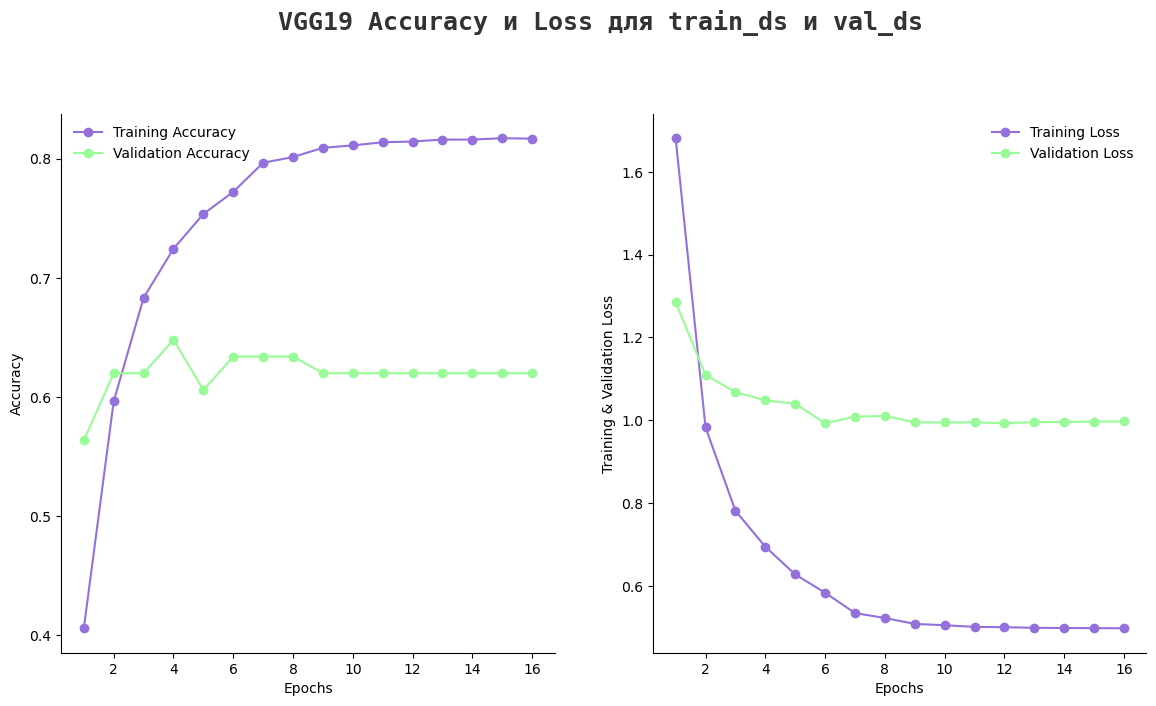

In [140]:
show_history(history_VGG19, 'VGG19')

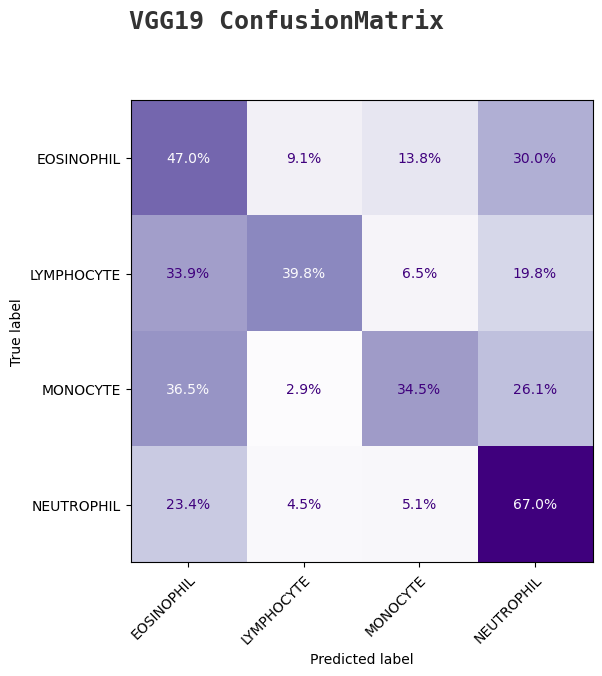

Classification report rebuilt from confusion matrix:
              precision    recall  f1-score   support

  EOSINOPHIL       0.33      0.47      0.39       623
  LYMPHOCYTE       0.71      0.40      0.51       620
    MONOCYTE       0.58      0.35      0.43       620
  NEUTROPHIL       0.47      0.67      0.55       624

    accuracy                           0.47      2487
   macro avg       0.52      0.47      0.47      2487
weighted avg       0.52      0.47      0.47      2487




In [144]:
#посмотрим матрицу ошибок сети VGG 19 
show_confusion_matrix(VGG19, 'VGG19')

In [147]:
#Посмотрим точность модели на примере тестового набора данных
test_accuracy = VGG19.evaluate(test_ds)[1]

78/78 ━━━━━━━━━━━━━━━━━━━━ 673s 8s/step - accuracy: 0.4465 - loss: 1.4523


In [148]:
test_accuracy

0.4712505042552948

Результаты обучения модели оставляют желать лучшего. По графикам метрик видно, что accuracy  и loss для валидационного набора данных проактически не изменяется. Скорее всего, это последствия несбалансированности классов валидационного датасета. Из матрицы ошибок можно заключить, что лучше всего модель узнает нейтрофилы, что и ожидаемо, так как их в валидационном наборе данных 61%. Попробуем переопределить валидационный датасет как 20% от тренировочного, что бы соблюсти баланс классов клеток и посмотреть, насколько улучшатся метрики модели в случае сбалансированного валидационного набора данных.

In [180]:
#Переопределим тренировочный и валидационный набор данных и предобработаем его
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=(IMG_WIDTH, IMG_HEIGHT),
                                                                 batch_size=BATCH_SIZE,
                                                                 validation_split=0.2, 
                                                                 subset='both',
                                                                 label_mode="int",
                                                                 shuffle=True,
                                                                 seed=42)

Found 9957 files belonging to 4 classes.
Using 7966 files for training.
Using 1991 files for validation.


In [181]:
#Проведем предобработку данных
ds_preprocessing(train_ds, 'Тренировочный')
ds_preprocessing(val_ds, 'Валидационный')

Тренировочный набор изображений: (32, 224, 224, 3)
Тренировочный набор меток: (32,)
Валидационный набор изображений: (32, 224, 224, 3)
Валидационный набор меток: (32,)


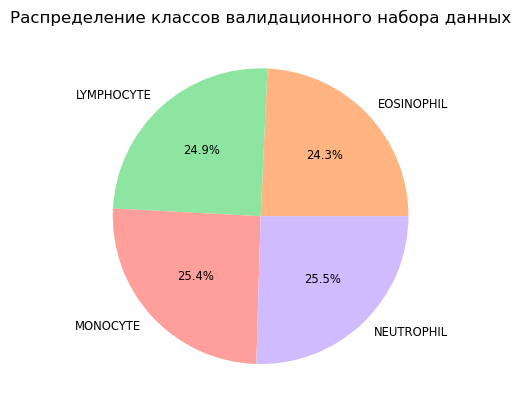

In [193]:
# Посмотрим балланс классов для валидационного набора данных  
show_class_distribution(val_ds, 'валидационного')

In [183]:
#Пересоберем сеть заново
from tensorflow.keras.applications.vgg19 import VGG19

# Загрузим предварительно обученную модель VGG19, отрежем ее верхний слой классификатор и заморозим оставшиеся слои
feature_extraction_layer = VGG19(include_top=False,
                                    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
feature_extraction_layer.trainable = False
# Построим модель, добавим к замороженным слоям аугментацию, GlobalAvgPool2D и Dense слой с 4 выходами
tf.random.set_seed(42)
VGG19 = tf.keras.Sequential([feature_extraction_layer,
                            layers.GlobalAvgPool2D(),
                            layers.Dense(4, activation="softmax")
                            ], name=name)
# Скомпилируем модель
VGG19.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Обучаем полученную модель на обновленных набоах данных
history_VGG19 = VGG19.fit(train_ds,
                        validation_data=val_ds,
                        epochs=30,
                        callbacks=[checkpoint_callback, reduce_lr, early_stopping_callback])

Epoch 1/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3190 - loss: 2.1292
Epoch 1: val_accuracy improved from -inf to 0.48719, saving model to C:\GB\Diploms_exam\diplom\blood\dataset2-master\dataset2-master\model_best.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 2063s 8s/step - accuracy: 0.3193 - loss: 2.1273 - val_accuracy: 0.4872 - val_loss: 1.2982 - learning_rate: 0.0010
Epoch 2/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5614 - loss: 1.0481
Epoch 2: val_accuracy improved from 0.48719 to 0.63988, saving model to C:\GB\Diploms_exam\diplom\blood\dataset2-master\dataset2-master\model_best.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 2060s 8s/step - accuracy: 0.5615 - loss: 1.0477 - val_accuracy: 0.6399 - val_loss: 0.8929 - learning_rate: 0.0010
Epoch 3/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6662 - loss: 0.8108
Epoch 3: val_accuracy improved from 0.63988 to 0.68709, saving model to C:\GB\Diploms_exam\diplom\blood\dataset2-master\dataset2-master\model_best.keras
249

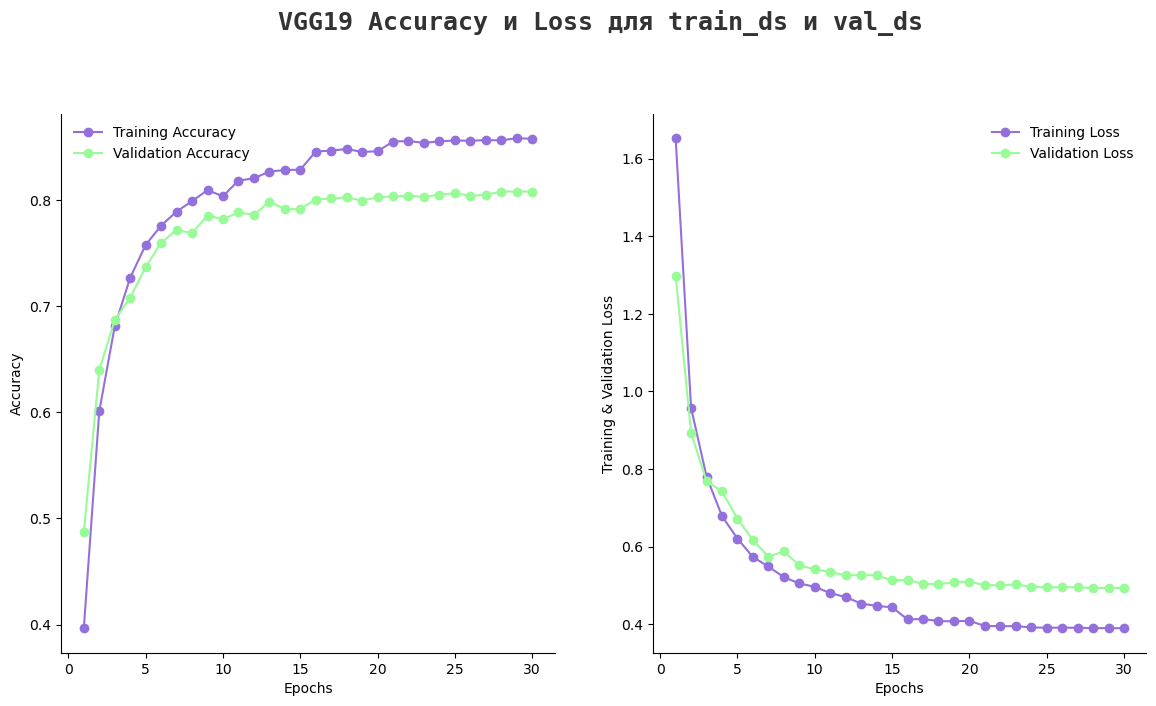

In [185]:
show_history(history_VGG19, 'VGG19')

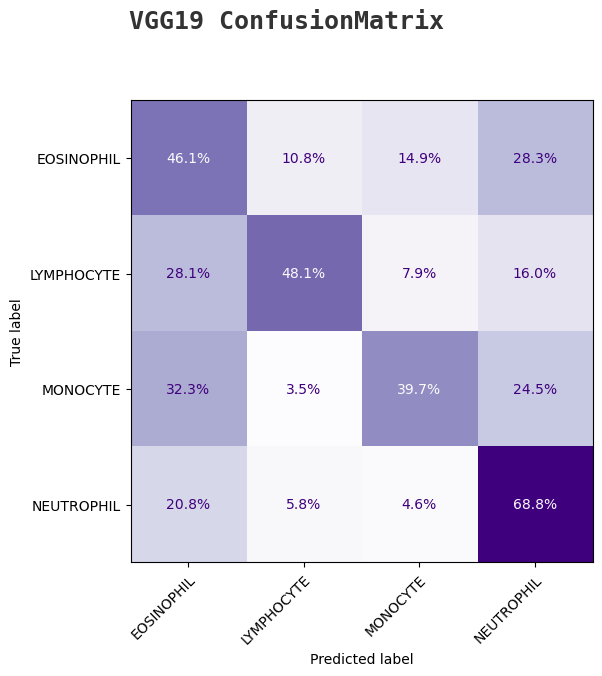

Classification report rebuilt from confusion matrix:
              precision    recall  f1-score   support

  EOSINOPHIL       0.36      0.46      0.41       623
  LYMPHOCYTE       0.70      0.48      0.57       620
    MONOCYTE       0.59      0.40      0.47       620
  NEUTROPHIL       0.50      0.69      0.58       624

    accuracy                           0.51      2487
   macro avg       0.54      0.51      0.51      2487
weighted avg       0.54      0.51      0.51      2487




In [188]:
#посмотрим матрицу ошибок сети VGG 19 
show_confusion_matrix(VGG19, 'VGG19')

In [189]:
write_model_book(VGG19)

249/249 ━━━━━━━━━━━━━━━━━━━━ 1336s 5s/step - accuracy: 0.8514 - loss: 0.4015
63/63 ━━━━━━━━━━━━━━━━━━━━ 333s 5s/step - accuracy: 0.8128 - loss: 0.4775
78/78 ━━━━━━━━━━━━━━━━━━━━ 454s 6s/step - accuracy: 0.4678 - loss: 1.6191


In [190]:
model_book

{'VGG19': {'train_accuracy': 0.8571428656578064,
  'val_accuracy': 0.8081366419792175,
  'test_accuracy': 0.5066344738006592},
 'ResNet50': {'train_accuracy': 0.942631185054779,
  'val_accuracy': 0.8975389003753662,
  'test_accuracy': 0.6465620994567871},
 'ResNet50_unfrozen': {'train_accuracy': 1.0,
  'val_accuracy': 1.0,
  'test_accuracy': 0.8689183592796326}}

In [186]:
#Сохраним веса модели в файл
VGG19.save_weights('model_VGG19.weights.h5')

Точность моделм на тестовом наборе данных увеличилась с 0,47 до 0.51 за счет сбалансированности классов валидационного датасета.

### 4. Модель VGG19 fine-tuning

In [498]:
#Разморозим слои базовой модели
feature_extraction_layer.trainable = True

In [500]:
# Посмотрим сколько слоев в модели
print("В базовой модели содержится: ", len(feature_extraction_layer.layers))

В базовой модели содержится:  22


In [501]:
#Разморозим слои 4 и 5 блока базовой модели.
for layer in feature_extraction_layer.layers[:13]:
  layer.trainable = False

In [503]:
#Посмотрим сколько параметров базовой модели обучаются теперь
feature_extraction_layer.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_72 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 16,518,656 (63.01 MB)

 Non-trainable params: 3,505,728 (13.37 MB)

In [504]:
#Уменьшим начальную скорость обучений, что бы не переобучить модель
learning_rate = 0.00001
# Скомпилируем модель
VGG19.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                metrics=["accuracy"])

In [505]:
#Посмотрим количество обучаемый параметров во всей модели
VGG19.summary()

Model: "VGG19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_48     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,026,436 (76.39 MB)

 Trainable params: 16,520,708 (63.02 MB)

 Non-trainable params: 3,505,728 (13.37 MB)

In [506]:
# Обучаем полученную модель 
history_VGG19_unfrozen = VGG19.fit(train_ds,
                        validation_data=val_ds,
                        epochs=15,
                        callbacks=[checkpoint_callback, reduce_lr, early_stopping_callback])

Epoch 1/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8550 - loss: 0.4970 
Epoch 1: val_accuracy improved from 0.85886 to 0.97288, saving model to C:\GB\Diploms_exam\diplom\blood\dataset2-master\dataset2-master\model_best.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 3283s 13s/step - accuracy: 0.8553 - loss: 0.4960 - val_accuracy: 0.9729 - val_loss: 0.0704 - learning_rate: 1.0000e-05
Epoch 2/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9870 - loss: 0.0368 
Epoch 2: val_accuracy improved from 0.97288 to 0.97941, saving model to C:\GB\Diploms_exam\diplom\blood\dataset2-master\dataset2-master\model_best.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 2898s 12s/step - accuracy: 0.9870 - loss: 0.0368 - val_accuracy: 0.9794 - val_loss: 0.0559 - learning_rate: 1.0000e-05
Epoch 3/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9934 - loss: 0.0266
Epoch 3: val_accuracy improved from 0.97941 to 0.99196, saving model to C:\GB\Diploms_exam\diplom\blood\dataset2-master\dataset2-master\mod

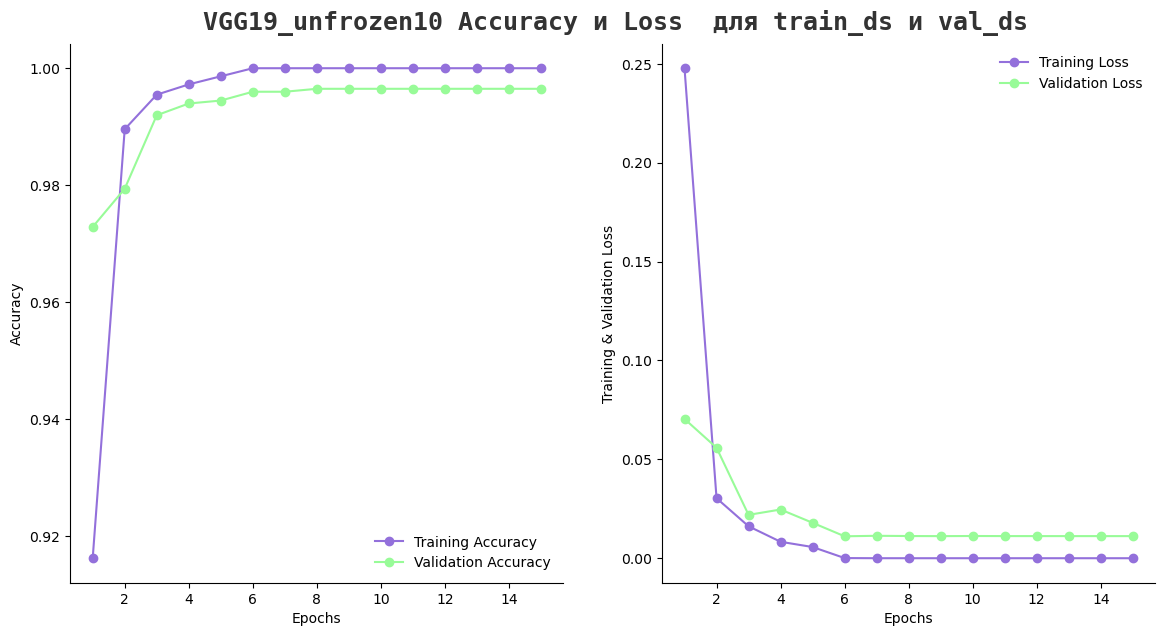

In [531]:
#Посмотрим графики метрик модели VGG19_unfrozen10
show_history(history_VGG19_unfrozen, 'VGG19_unfrozen10')

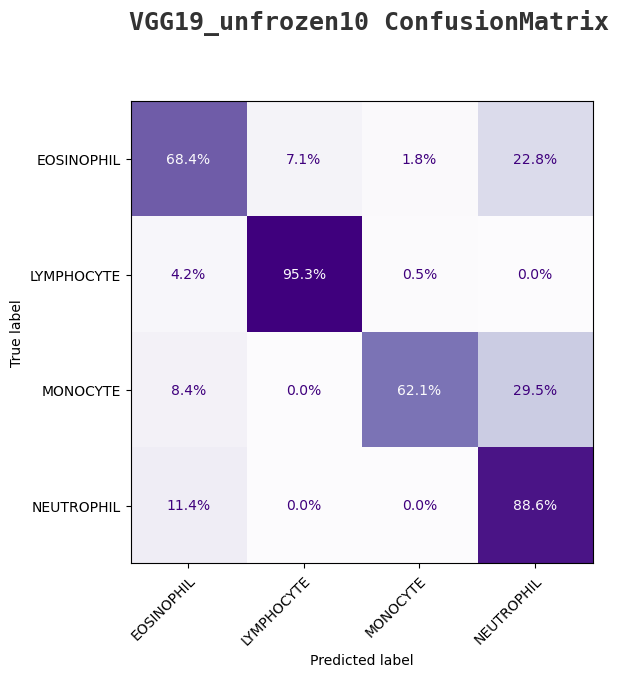

Classification report rebuilt from confusion matrix:
              precision    recall  f1-score   support

  EOSINOPHIL       0.74      0.68      0.71       623
  LYMPHOCYTE       0.93      0.95      0.94       620
    MONOCYTE       0.96      0.62      0.76       620
  NEUTROPHIL       0.63      0.89      0.74       624

    accuracy                           0.79      2487
   macro avg       0.82      0.79      0.79      2487
weighted avg       0.82      0.79      0.79      2487




In [518]:
#Матрица ошибок и классификационный отчет
show_confusion_matrix(VGG19, 'VGG19_unfrozen10')

In [533]:
name = "VGG19_unfroztn10"
write_model_book(VGG19)

249/249 ━━━━━━━━━━━━━━━━━━━━ 1556s 6s/step - accuracy: 1.0000 - loss: 1.4031e-05
63/63 ━━━━━━━━━━━━━━━━━━━━ 432s 7s/step - accuracy: 0.9981 - loss: 0.0080
78/78 ━━━━━━━━━━━━━━━━━━━━ 486s 6s/step - accuracy: 0.7535 - loss: 1.8823


In [534]:
model_book

{'VGG19': {'train_accuracy': 0.8571428656578064,
  'val_accuracy': 0.8081366419792175,
  'test_accuracy': 0.5066344738006592},
 'ResNet50': {'train_accuracy': 0.942631185054779,
  'val_accuracy': 0.8975389003753662,
  'test_accuracy': 0.6465620994567871},
 'ResNet50_unfrozen': {'train_accuracy': 1.0,
  'val_accuracy': 1.0,
  'test_accuracy': 0.8689183592796326},
 'VGG19_unfroztn10': {'train_accuracy': 1.0,
  'val_accuracy': 0.9959819316864014,
  'test_accuracy': 0.7860876321792603}}

In [536]:
VGG19.save_weights('model_VGG19_unfrozen10.weights.h5')

### 5. Модель ResNet50 feature extraction

In [34]:
# Соберем нейросеть, назовем ее
name = 'model_ResNet50'

# Загрузим предварительно обученную модель Resnet50 и сохраним ее как слой.
feature_extraction_layer = ResNet50(include_top=False,
                                    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Заморозим ее слои, что бы они не обучались
feature_extraction_layer.trainable = False

In [109]:
feature_extraction_layer.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_18[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [110]:
#Посмотрим на слои получившейся модели
model_ResNet50.summary()

Model: "model_ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,612,302 (90.07 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 16,394 (64.04 KB)

In [40]:
# Построим модель, добавим к замороженным GlobalAvgPool2D и Dense слой с 4 выходами
tf.random.set_seed(42)
model_ResNet50 = tf.keras.Sequential([feature_extraction_layer,
                            layers.GlobalAvgPool2D(),
                            layers.Dense(4, activation="softmax")
                            ], name=name)
# Скомпилируем модель
model_ResNet50.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Обучаем полученную модель на обновленных набоах данных
history_ResNet50 = model_ResNet50.fit(train_ds,
                        validation_data=val_ds,
                        epochs=30,
                        callbacks=[checkpoint_callback, reduce_lr, early_stopping_callback])

Epoch 1/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4766 - loss: 1.1949
Epoch 1: val_accuracy did not improve from 0.73239
249/249 ━━━━━━━━━━━━━━━━━━━━ 512s 2s/step - accuracy: 0.4770 - loss: 1.1942 - val_accuracy: 0.6720 - val_loss: 0.8378 - learning_rate: 0.0010
Epoch 2/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7214 - loss: 0.7545
Epoch 2: val_accuracy improved from 0.73239 to 0.78654, saving model to C:\GB\Diploms_exam\diplom\blood\dataset2-master\dataset2-master\model_best.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 514s 2s/step - accuracy: 0.7214 - loss: 0.7544 - val_accuracy: 0.7865 - val_loss: 0.6481 - learning_rate: 0.0010
Epoch 3/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7905 - loss: 0.6082
Epoch 3: val_accuracy did not improve from 0.78654
249/249 ━━━━━━━━━━━━━━━━━━━━ 521s 2s/step - accuracy: 0.7905 - loss: 0.6082 - val_accuracy: 0.7810 - val_loss: 0.6068 - learning_rate: 0.0010
Epoch 4/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0

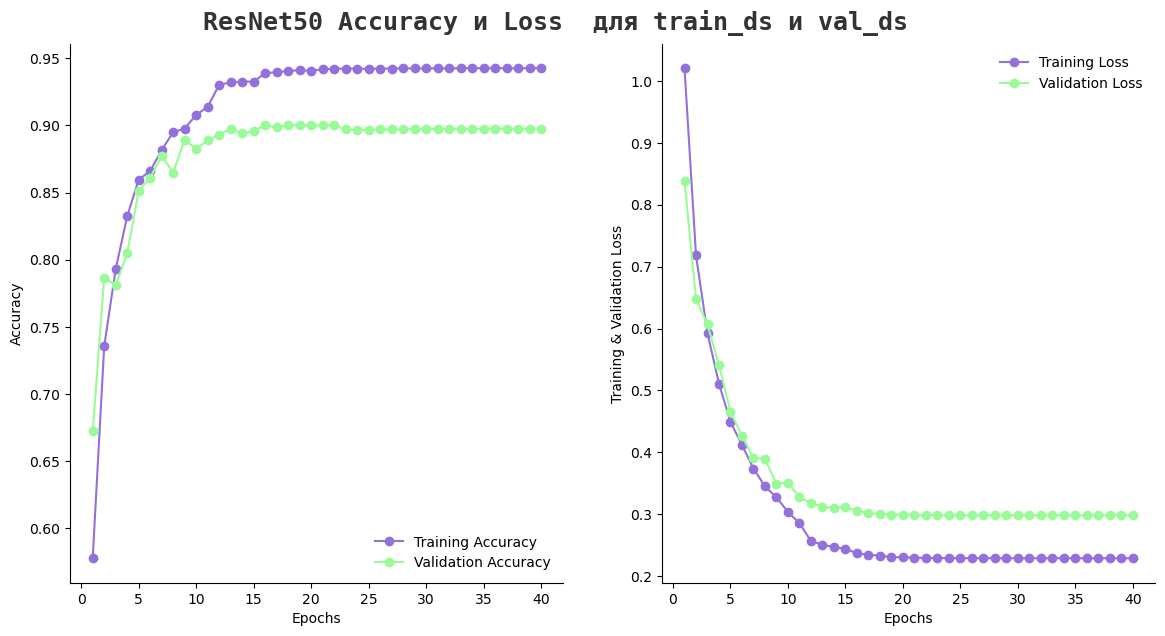

In [539]:
show_history(history_ResNet50, 'ResNet50')

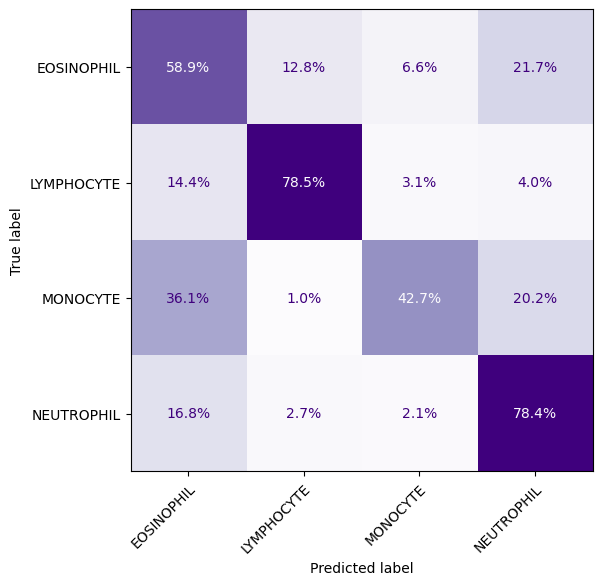

Classification report rebuilt from confusion matrix:
              precision    recall  f1-score   support

  EOSINOPHIL       0.47      0.59      0.52       623
  LYMPHOCYTE       0.83      0.79      0.80       620
    MONOCYTE       0.78      0.43      0.55       620
  NEUTROPHIL       0.63      0.78      0.70       624

    accuracy                           0.65      2487
   macro avg       0.68      0.65      0.64      2487
weighted avg       0.68      0.65      0.64      2487




In [43]:
#Посмотрим матрицу ошибок для модели
show_confusion_matrix(model_ResNet50)

In [44]:
#Сохраним веса модедли
model_ResNet50.save_weights('model_ResNet50.weights.h5')

In [97]:
write_model_book(model_ResNet50)

249/249 ━━━━━━━━━━━━━━━━━━━━ 402s 2s/step - accuracy: 0.9376 - loss: 0.2345
63/63 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.8961 - loss: 0.3063
78/78 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.6259 - loss: 0.9347


In [537]:
model_book

{'VGG19': {'train_accuracy': 0.8571428656578064,
  'val_accuracy': 0.8081366419792175,
  'test_accuracy': 0.5066344738006592},
 'ResNet50': {'train_accuracy': 0.942631185054779,
  'val_accuracy': 0.8975389003753662,
  'test_accuracy': 0.6465620994567871},
 'ResNet50_unfrozen': {'train_accuracy': 1.0,
  'val_accuracy': 1.0,
  'test_accuracy': 0.8689183592796326},
 'VGG19_unfroztn10': {'train_accuracy': 1.0,
  'val_accuracy': 0.9959819316864014,
  'test_accuracy': 0.7860876321792603}}

### 6. Модель ResNet50 fine-tuning, разморозка трети слоев

In [601]:
feature_extraction_layer.trainable = True
feature_extraction_layer.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_81      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_81[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [575]:
# Посмотрим сколько слоев в модели
print("В базовой модели содержится: ", len(feature_extraction_layer.layers))

В базовой модели содержится:  175


In [576]:
#Разморозим треть слоев базовой модели.
for layer in feature_extraction_layer.layers[:117]:
  layer.trainable = False
feature_extraction_layer.summary()  


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_78      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_78[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 17,479,168 (66.68 MB)

 Non-trainable params: 6,108,544 (23.30 MB)

In [577]:
#Уменьшим начальную скорость обучений, что бы не переобучить модель
learning_rate = 0.00001
# Скомпилируем модель
model_ResNet50.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                metrics=["accuracy"])

In [578]:
model_ResNet50.summary()

Model: "model_ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_52     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 17,487,364 (66.71 MB)

 Non-trainable params: 6,108,544 (23.30 MB)

In [579]:
# Обучаем полученную модель 
history_ResNet50_unfrozen59 = model_ResNet50.fit(train_ds,
                        validation_data=val_ds,
                        epochs=10,
                        callbacks=[checkpoint_callback, reduce_lr, early_stopping_callback])

Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 1.0000 - loss: 2.9516e-04
Epoch 1: val_accuracy improved from 0.99648 to 0.99799, saving model to C:\GB\Diploms_exam\diplom\blood\dataset2-master\dataset2-master\model_best.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 1021s 4s/step - accuracy: 1.0000 - loss: 2.9515e-04 - val_accuracy: 0.9980 - val_loss: 0.0058 - learning_rate: 1.0000e-05
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9996 - loss: 8.9265e-04
Epoch 2: val_accuracy did not improve from 0.99799
249/249 ━━━━━━━━━━━━━━━━━━━━ 828s 3s/step - accuracy: 0.9996 - loss: 8.9093e-04 - val_accuracy: 0.9980 - val_loss: 0.0058 - learning_rate: 1.0000e-05
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 1.0000 - loss: 2.7672e-04
Epoch 3: val_accuracy did not improve from 0.99799

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
249/249 ━━━━━━━━━━━━━━━━━━━━ 787s 3s/step - accuracy: 1.0000 - loss: 2.7669e-04 - val_accuracy: 0.9

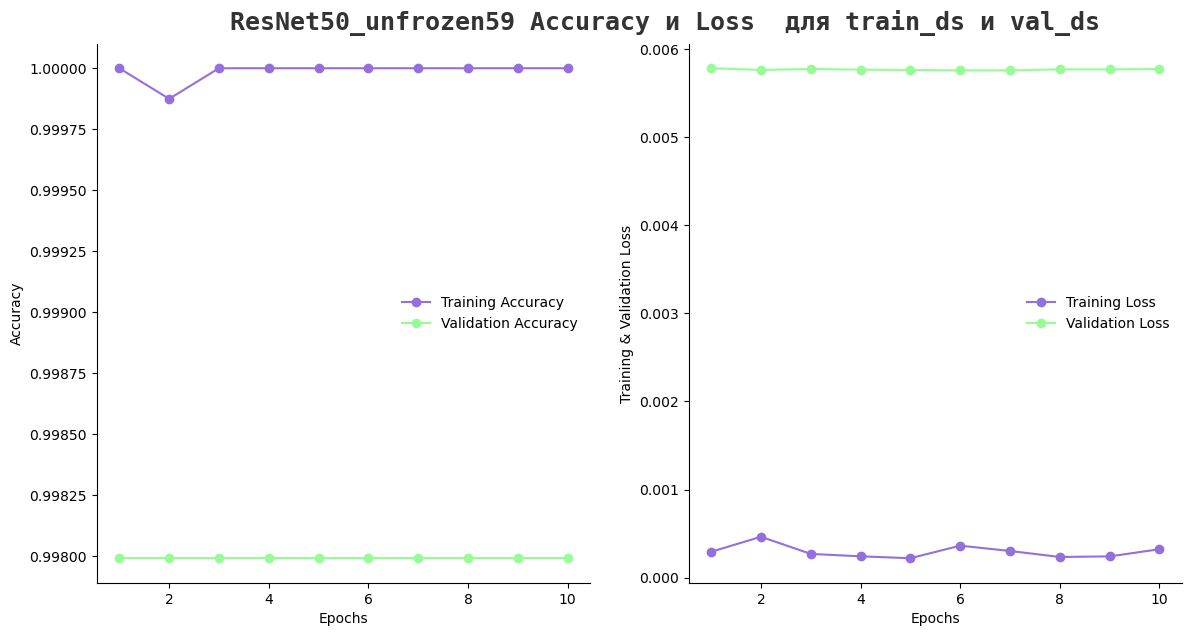

In [580]:
name = "ResNet50_unfrozen59"
#Графики метрик
show_history(history_ResNet50_unfrozen59, 'ResNet50_unfrozen59')

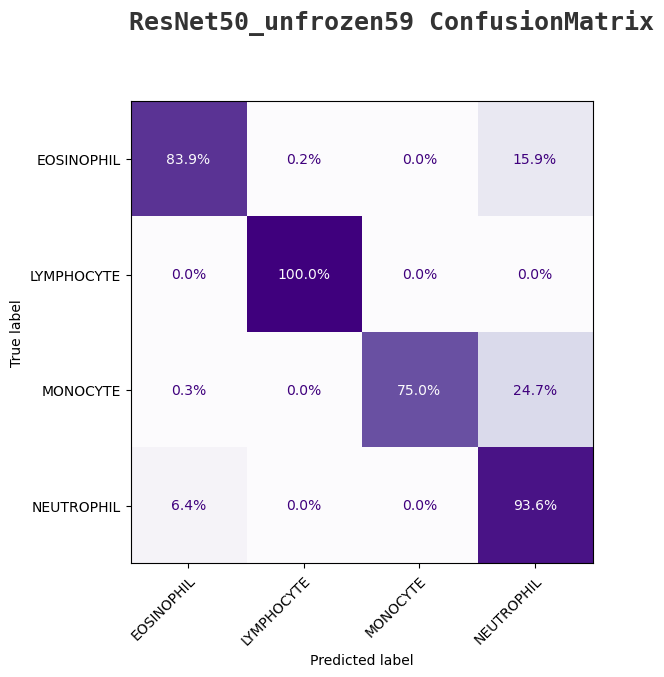

Classification report rebuilt from confusion matrix:
              precision    recall  f1-score   support

  EOSINOPHIL       0.93      0.84      0.88       623
  LYMPHOCYTE       1.00      1.00      1.00       620
    MONOCYTE       1.00      0.75      0.86       620
  NEUTROPHIL       0.70      0.94      0.80       624

    accuracy                           0.88      2487
   macro avg       0.91      0.88      0.88      2487
weighted avg       0.91      0.88      0.88      2487




In [581]:
#Посмотрим матрицу ошибок для модели
show_confusion_matrix(model_ResNet50, name)

In [582]:
write_model_book(model_ResNet50)

249/249 ━━━━━━━━━━━━━━━━━━━━ 393s 2s/step - accuracy: 1.0000 - loss: 1.3161e-04
63/63 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.9985 - loss: 0.0037
78/78 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.8736 - loss: 1.4465


In [583]:
model_book

{'VGG19': {'train_accuracy': 0.8571428656578064,
  'val_accuracy': 0.8081366419792175,
  'test_accuracy': 0.5066344738006592},
 'ResNet50': {'train_accuracy': 0.942631185054779,
  'val_accuracy': 0.8975389003753662,
  'test_accuracy': 0.6465620994567871},
 'ResNet50_unfrozen': {'train_accuracy': 1.0,
  'val_accuracy': 1.0,
  'test_accuracy': 0.8689183592796326},
 'VGG19_unfroztn10': {'train_accuracy': 1.0,
  'val_accuracy': 0.9959819316864014,
  'test_accuracy': 0.7860876321792603},
 'ResNet50_unfrozen59': {'train_accuracy': 1.0,
  'val_accuracy': 0.9979909658432007,
  'test_accuracy': 0.8813831806182861}}

In [584]:
model_ResNet50.save_weights('model_ResNet50_unfrozen59.weights.h5')

### 7. Модель ResNet50 fine-tuning, полная разморозка модели

In [589]:
#Чтобы вернуться к замороженной модели и начать настройку от ее параметров, заново загрузим и соберем модель на основе ResNet50
name = 'model_ResNet50'

# Загрузим предварительно обученную модель Resnet50 и сохраним ее как слой.
feature_extraction_layer = ResNet50(include_top=False,
                                    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Заморозим ее слои, что бы они не обучались
feature_extraction_layer.trainable = False

In [590]:
feature_extraction_layer.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_81      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_81[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [591]:
# Построим модель, добавим к замороженным слоям аугментацию, GlobalAvgPool2D и Dense слой с 4 выходами
tf.random.set_seed(42)
model_ResNet50 = tf.keras.Sequential([feature_extraction_layer,
                            layers.GlobalAvgPool2D(),
                            layers.Dense(4, activation="softmax")
                            ], name=name)
# Скомпилируем модель
model_ResNet50.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

In [592]:
history_ResNet50 = model_ResNet50.fit(train_ds,
                        validation_data=val_ds,
                        epochs=1,
                        callbacks=[checkpoint_callback, reduce_lr, early_stopping_callback])

249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4457 - loss: 1.2394
Epoch 1: val_accuracy did not improve from 0.99799
249/249 ━━━━━━━━━━━━━━━━━━━━ 528s 2s/step - accuracy: 0.4461 - loss: 1.2387 - val_accuracy: 0.6690 - val_loss: 0.8348 - learning_rate: 0.0010


In [593]:
model_ResNet50.summary()

Model: "model_ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_53     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,612,302 (90.07 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 16,394 (64.04 KB)

In [594]:
#Загрузим в получившуюся модель веса после прошлого обучения
model_ResNet50.load_weights('model_ResNet50.weights.h5')

In [595]:
#Попробуем настроить модель с полностью размороженными слоями
feature_extraction_layer.trainable = True
feature_extraction_layer.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_81      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_81[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [596]:
#Уменьшим начальную скорость обучений, что бы не переобучить модель
learning_rate = 0.00001
# Скомпилируем модель
model_ResNet50.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                metrics=["accuracy"])

In [597]:
model_ResNet50.summary()



Model: "model_ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_53     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 23,542,788 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [600]:
# Обучаем полученную модель 
history_ResNet50_unfrozen = model_ResNet50.fit(train_ds,
                        validation_data=val_ds,
                        epochs=7,
                        callbacks=[checkpoint_callback, reduce_lr, early_stopping_callback])

Epoch 1/7
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 1.0000 - loss: 6.5108e-04
Epoch 1: val_accuracy did not improve from 0.99799
249/249 ━━━━━━━━━━━━━━━━━━━━ 2149s 9s/step - accuracy: 1.0000 - loss: 6.5374e-04 - val_accuracy: 0.9980 - val_loss: 0.0060 - learning_rate: 1.0000e-05
Epoch 2/7
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9999 - loss: 7.1987e-04
Epoch 2: val_accuracy did not improve from 0.99799
249/249 ━━━━━━━━━━━━━━━━━━━━ 2068s 8s/step - accuracy: 0.9999 - loss: 7.2242e-04 - val_accuracy: 0.9980 - val_loss: 0.0060 - learning_rate: 1.0000e-05
Epoch 3/7
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 4.7555e-04
Epoch 3: val_accuracy did not improve from 0.99799

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
249/249 ━━━━━━━━━━━━━━━━━━━━ 1964s 8s/step - accuracy: 1.0000 - loss: 4.7532e-04 - val_accuracy: 0.9980 - val_loss: 0.0059 - learning_rate: 1.0000e-05
Epoch 4/7
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - 

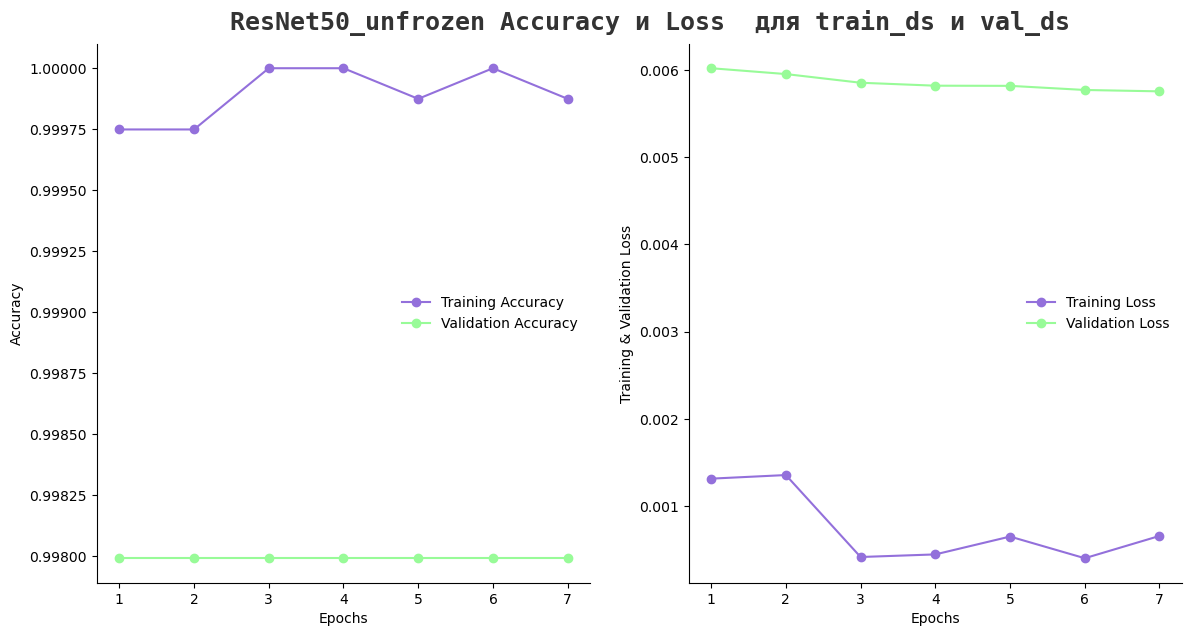

In [602]:
name='ResNet50_unfrozen'
#Графики метрик
show_history(history_ResNet50_unfrozen, name)

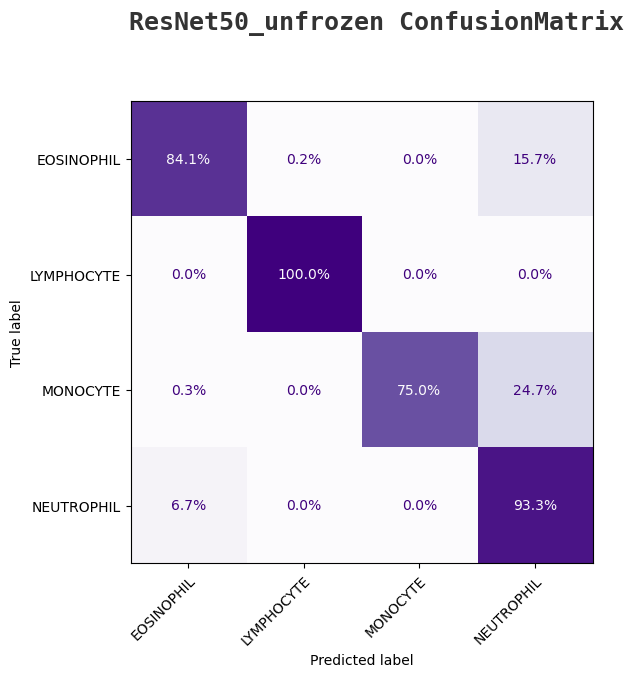

Classification report rebuilt from confusion matrix:
              precision    recall  f1-score   support

  EOSINOPHIL       0.92      0.84      0.88       623
  LYMPHOCYTE       1.00      1.00      1.00       620
    MONOCYTE       1.00      0.75      0.86       620
  NEUTROPHIL       0.70      0.93      0.80       624

    accuracy                           0.88      2487
   macro avg       0.90      0.88      0.88      2487
weighted avg       0.90      0.88      0.88      2487




In [603]:
#Посмотрим матрицу ошибок для модели
show_confusion_matrix(model_ResNet50, name)

In [604]:
write_model_book(model_ResNet50)

249/249 ━━━━━━━━━━━━━━━━━━━━ 482s 2s/step - accuracy: 1.0000 - loss: 8.8789e-05
63/63 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.9985 - loss: 0.0041
78/78 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.8743 - loss: 1.4476


In [605]:
model_book

{'VGG19': {'train_accuracy': 0.8571428656578064,
  'val_accuracy': 0.8081366419792175,
  'test_accuracy': 0.5066344738006592},
 'ResNet50': {'train_accuracy': 0.942631185054779,
  'val_accuracy': 0.8975389003753662,
  'test_accuracy': 0.6465620994567871},
 'ResNet50_unfrozen': {'train_accuracy': 1.0,
  'val_accuracy': 0.9979909658432007,
  'test_accuracy': 0.8809810876846313},
 'VGG19_unfroztn10': {'train_accuracy': 1.0,
  'val_accuracy': 0.9959819316864014,
  'test_accuracy': 0.7860876321792603},
 'ResNet50_unfrozen59': {'train_accuracy': 1.0,
  'val_accuracy': 0.9979909658432007,
  'test_accuracy': 0.8813831806182861}}

In [608]:
model_ResNet50.save_weights('model_ResNet50_unfrozen.weights.h5')

### 8. Заключение

In [638]:
#Для удобства переведем словарь в датафрейм пандас
result_df= pd.DataFrame.from_dict(model_book).transpose().sort_values(by='test_accuracy')

In [641]:
result_df

,train_accuracy,val_accuracy,test_accuracy
VGG19,0.857143,0.808137,0.506634
ResNet50,0.942631,0.897539,0.646562
VGG19_unfroztn10,1.000000,0.995982,0.786088
ResNet50_unfrozen,1.000000,0.997991,0.880981
ResNet50_unfrozen59,1.000000,0.997991,0.881383


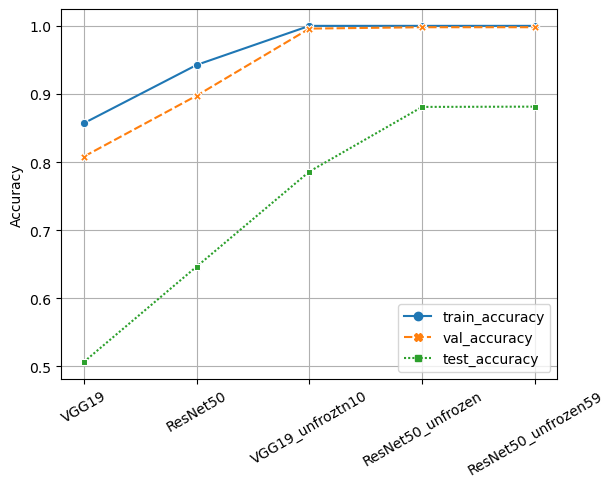

In [639]:
# Построим графики изменения характеристик моделей
sns.lineplot(data=result_df, markers=True)
plt.grid()
plt.ylabel("Accuracy")
plt.xticks(rotation=30)
plt.show()

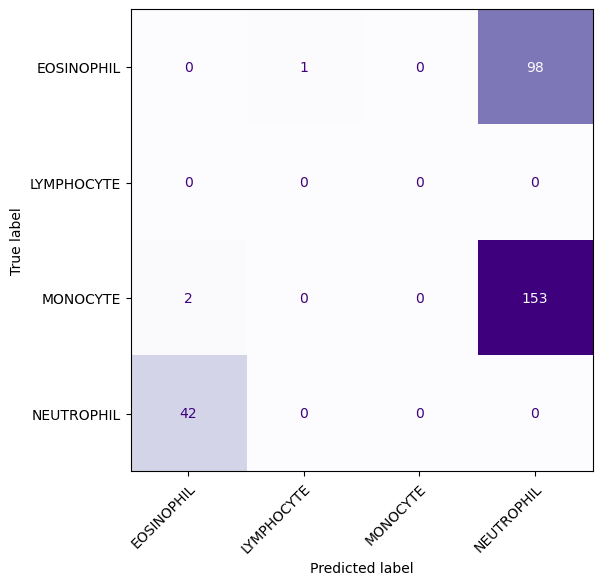

In [611]:
#Посмотрим памые распространенные ошибки сети ResNet50
y_pred = []
y_pred_proba = []
y_true = []

# Проходим по набору данных и сохраняем метки
for image_batch, label_batch in test_ds:
   y_true.append(label_batch)
   preds = model_ResNet50.predict(image_batch, verbose=0)
   y_pred_proba.append(preds)
   y_pred.append(np.argmax(preds, axis=-1))

# Объединим и преобразуем предсказанные и реальные метки 
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = tf.cast(correct_labels, "int64")
predicted_labels = tf.concat([item for item in y_pred], axis = 0)
sample_weight = (correct_labels != predicted_labels)
fig, axes = plt.subplots(figsize=(10,6))
ConfusionMatrixDisplay.from_predictions(y_true=correct_labels,
                                        y_pred=predicted_labels,
                                        display_labels=class_names,
                                        cmap="Purples",
                                        sample_weight=sample_weight,
                                        ax=axes,
                                        colorbar=False)
axes.set_xticklabels(labels=class_names, rotation=45, ha='right', rotation_mode='anchor')
plt.show()

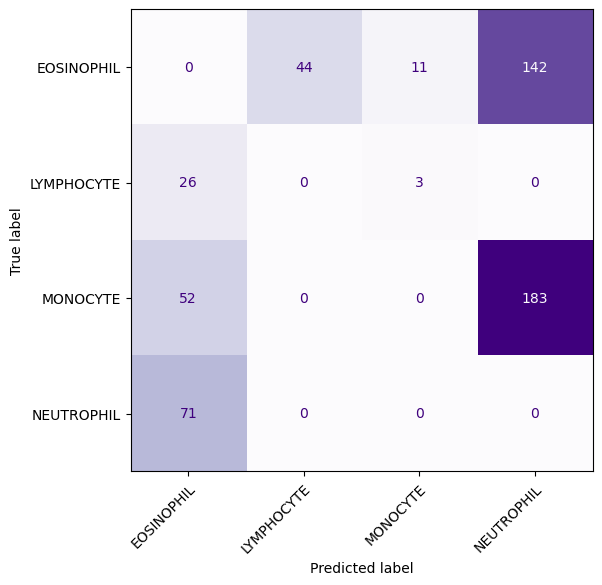

In [614]:
#Посмотрим памые распространенные ошибки сети VGG19
y_pred = []
y_pred_proba = []
y_true = []

# Проходим по набору данных и сохраняем метки
for image_batch, label_batch in test_ds:
   y_true.append(label_batch)
   preds = VGG19.predict(image_batch, verbose=0)
   y_pred_proba.append(preds)
   y_pred.append(np.argmax(preds, axis=-1))

# Объединим и преобразуем предсказанные и реальные метки 
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = tf.cast(correct_labels, "int64")
predicted_labels = tf.concat([item for item in y_pred], axis = 0)
sample_weight = (correct_labels != predicted_labels)
fig, axes = plt.subplots(figsize=(10,6))
ConfusionMatrixDisplay.from_predictions(y_true=correct_labels,
                                        y_pred=predicted_labels,
                                        display_labels=class_names,
                                        cmap="Purples",
                                        sample_weight=sample_weight,
                                        ax=axes,
                                        colorbar=False)
axes.set_xticklabels(labels=class_names, rotation=45, ha='right', rotation_mode='anchor')
plt.show()

Ошибки одинаковы. Видим, что топ три ошибок: моноциты принимаются сетями за нейтрофилы, эозинофилы за нейтрофилы, и нейтрофилы за эозинофилы. 